First bit of eda into python

In [10]:
import pandas as pd
import pyarrow as pa 
import pyarrow.parquet as pq 
import os
import time
import numpy as np
import pyarrow as pa
from scipy.stats import skew, kurtosis

# Preprocessing

Original data frame without the voltatility into parquet

In [32]:
import pandas as pd
import pyarrow as pa 
import pyarrow.parquet as pq 
import os
import time

start_time = time.time()


data_dir = "Optiver/individual_book_train"
parquet_dir = "pardata"

os.makedirs(parquet_dir, exist_ok=True)

i = 0 
for filename in os.listdir(data_dir):
    if filename.endswith(".csv"): 
        file_path = os.path.join(data_dir, filename)
        df = pd.read_csv(file_path)
        
    
        table = pa.Table.from_pandas(df)
        parquet_file = os.path.splitext(filename)[0] + '.parquet'
        pq.write_table(table, os.path.join(parquet_dir, parquet_file))
    i += 1
    if i % 10 == 0:
        print(f"Loaded {i} stocks")
        
end_time = time.time()    
print(f"Time to load: {end_time - start_time}")

Loaded 10 stocks
Loaded 20 stocks
Loaded 30 stocks
Loaded 40 stocks
Loaded 50 stocks
Loaded 60 stocks
Loaded 70 stocks
Loaded 80 stocks
Loaded 90 stocks
Loaded 100 stocks
Loaded 110 stocks
Time to load: 490.84207677841187


With voltalility 

In [44]:
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import os
import time

def compute_wap_and_spread(df):
    """
    Compute WAP (Weighted Average Price) and Bid-Ask Spread.
    
    Parameters: df (pd.DataFrame): Must contain 'bid_price1', 'ask_price1', 'bid_size1', and 'ask_size1'.
    
    Returns: pd.DataFrame: DataFrame with 'WAP' and 'BidAskSpread' columns added.
    """
    df = df.copy()
    denom = df["bid_size1"] + df["ask_size1"]
    df["WAP"] = np.where(denom != 0,
                         (df["bid_price1"] * df["ask_size1"] + df["ask_price1"] * df["bid_size1"]) / denom,
                         np.nan)
    
    df["BidAskSpread"] = np.where(df["bid_price1"] != 0,
                                  df["ask_price1"] / df["bid_price1"] - 1,
                                  np.nan)
    return df

def compute_log_returns(df):
    """
    Compute per-time_id log returns for a given stock DataFrame.
    
    Parameters:
        df (pd.DataFrame): Must contain 'time_id', 'seconds_in_bucket', and 'WAP' columns.
    
    Returns:
        list of pd.DataFrame: Each DataFrame has 'time' and 'log_return' columns for one time_id.
    """
    log_r1 = []
    time_IDs = df["time_id"].unique()

    for time_id in time_IDs:
        df_group = df[df["time_id"] == time_id]
        sec = df_group["seconds_in_bucket"].values
        price = df_group["WAP"].values

        if len(price) < 2:
            continue

        log_r = np.log(price[1:] / price[:-1])

        temp_df = pd.DataFrame({
            "time": sec[1:],
            "log_return": log_r
        })

        full_time_range = np.arange(1, 601)
        missing_times = np.setdiff1d(full_time_range, temp_df["time"].values)

        if len(missing_times) > 0:
            filler_df = pd.DataFrame({
                "time": missing_times,
                "log_return": 0
            })
            temp_df = pd.concat([temp_df, filler_df], ignore_index=True)
            temp_df = temp_df.sort_values("time").reset_index(drop=True)

        temp_df["time_id"] = time_id
        log_r1.append(temp_df)

    return log_r1

def comp_vol(x):
    """Compute realized volatility (square root of sum of squared log returns)."""
    return np.sqrt(np.sum(np.square(x)))

def compute_volatility(log_r_list):
     """
    log_r_list: list of DataFrames with 'time' and 'log_return' columns (one per time_id).
    
    Returns:
    List of DataFrames with 'time_bucket' and 'volatility' columns.
    """
    vol_list = []

    for df in log_r_list:
        df = df.copy()
        df["time_bucket"] = np.ceil(df["time"] / 30).astype(int)
        
        vol_df = df.groupby("time_bucket")["log_return"].apply(comp_vol).reset_index()
        vol_df.columns = ["time_bucket", "volatility"]
        
        if "time_id" in df.columns:
            vol_df["time_id"] = df["time_id"].iloc[0]
        
        vol_list.append(vol_df)

    return pd.concat(vol_list, ignore_index=True) if vol_list else pd.DataFrame()

data_dir = "Optiver/individual_book_train"
parquet_dir = "pardata2"
os.makedirs(parquet_dir, exist_ok=True)

start_time = time.time()
i = 0

for filename in os.listdir(data_dir):
    if filename.endswith(".csv"): 
        file_path = os.path.join(data_dir, filename)
        df = pd.read_csv(file_path)

        df = compute_wap_and_spread(df)

        log_r_list = compute_log_returns(df)
        if not log_r_list:
            continue

        log_returns_df = pd.concat(log_r_list, ignore_index=True)
        vol_df = compute_volatility(log_r_list)

        df = df.merge(log_returns_df, how="left", left_on=["time_id", "seconds_in_bucket"],
                      right_on=["time_id", "time"])
        df.drop(columns=["time"], inplace=True)

        df["time_bucket"] = np.ceil(df["seconds_in_bucket"] / 30).astype(int)
        df = df.merge(vol_df, how="left", on=["time_id", "time_bucket"])

        table = pa.Table.from_pandas(df)
        parquet_file = os.path.splitext(filename)[0] + '.parquet'
        pq.write_table(table, os.path.join(parquet_dir, parquet_file))

        i += 1
        if i % 10 == 0:
            print(f"Processed {i} stocks")

end_time = time.time()
print(f"Total processing time: {end_time - start_time:.2f} seconds")

Processed 10 stocks
Processed 20 stocks
Processed 30 stocks
Processed 40 stocks
Processed 50 stocks
Processed 60 stocks
Processed 70 stocks
Processed 80 stocks
Processed 90 stocks
Processed 100 stocks
Processed 110 stocks
Total processing time: 5626.11 seconds


In [49]:
df1 = pd.read_parquet('pardata2/stock_0.parquet')
df1.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id,WAP,BidAskSpread,log_return,time_bucket,volatility
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100,0,1.001434,0.000878,NaN,0,NaN
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,0,1.001448,0.000878,0.000014,1,0.001057
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,0,1.001448,0.000878,0.000000,1,0.001057
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0,1.001443,0.000878,-0.000005,1,0.001057
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0,1.001443,0.000878,0.000000,1,0.001057


## Reloading the data

In [6]:
def extract_volatility_by_bucket(df):
    """
    Returns a DataFrame with unique (time_id, time_bucket, volatility) combinations.
    Assumes 'volatility' already exists in the input DataFrame.
    """
    return (
        df[["time_id", "time_bucket", "volatility"]]
        .dropna(subset=["volatility"])
        .drop_duplicates()
        .reset_index(drop=True)
    )


In [7]:
data_dir = "pardata2"
volatilities = {}

for filename in os.listdir(data_dir):
    if filename.endswith(".parquet"):
        stock_name = os.path.splitext(filename)[0]
        file_path = os.path.join(data_dir, filename)
        
        df = pd.read_parquet(file_path)

        vol_df = extract_volatility_by_bucket(df)
        
        volatilities[stock_name] = vol_df
        
volatilities['stock_0'].head()

,time_id,time_bucket,volatility
0,5,1,0.001057
1,5,2,0.001266
2,5,3,0.001091
3,5,4,0.000366
4,5,5,0.001339


## Initital summaries

In [11]:
def describe_volatility_and_log_returns(stocks_dict, time_id=5):
    volatility_stats_list = []

    for stock_name, df in stocks_dict.items():
        df_filtered = df[df["time_id"] == time_id]

        if df_filtered.empty:
            continue

        # Handle volatility
        if "volatility" in df_filtered.columns:
            volatilities = df_filtered["volatility"].dropna()
            if len(volatilities) > 0:
                volatility_stats_list.append({
                    "stock": stock_name,
                    "mean": volatilities.mean(),
                    "std": volatilities.std(),
                    "min": volatilities.min(),
                    "max": volatilities.max(),
                    "skewness": skew(volatilities),
                    "kurtosis": kurtosis(volatilities)
                })

    volatility_df = pd.DataFrame(volatility_stats_list)

    return volatility_df


In [13]:
volatility_summary = describe_volatility_and_log_returns(volatilities, time_id=5)
print("\nVolatility Stats:")
print(volatility_summary.head())


outliers_df = volatility_summary[(volatility_summary["skewness"] < -0.75) | (volatility_summary["skewness"] > 0.75)]
print("\n Stocks with skewness outside [-0.75, 0.75]:")
print(outliers_df)



Volatility Stats:
       stock      mean       std       min       max  skewness  kurtosis
0    stock_0  0.000932  0.000388  0.000157  0.001563 -0.186211 -0.767043
1    stock_1  0.001359  0.000330  0.000699  0.001890 -0.112447 -0.731638
2   stock_10  0.001147  0.000372  0.000452  0.001889 -0.219360 -0.330725
3  stock_100  0.001008  0.000388  0.000306  0.001617  0.117505 -0.982270
4  stock_101  0.001169  0.000259  0.000546  0.001638 -0.642275  0.161857

 Stocks with skewness outside [-0.5, 0.5]:
         stock      mean       std       min       max  skewness  kurtosis
17   stock_114  0.000787  0.000258  0.000358  0.001494  0.851948  1.229535
18   stock_115  0.000894  0.000408  0.000449  0.002313  2.077638  5.370436
33    stock_18  0.003041  0.001080  0.001277  0.005858  0.985311  0.905953
36    stock_20  0.000599  0.000127  0.000317  0.000754 -0.817834 -0.402844
38    stock_22  0.001046  0.000360  0.000626  0.002114  1.269566  1.801575
46    stock_31  0.001080  0.000631  0.000148  0.0

Kurtosis and Skewness are used to determine distribution shape. Usually, if the skewness is between-0.5 to 0.5 the data can be viewed as nearly symmetrical.  All stocks except Hansa Biopharma are leptokurtic.

C:\Users\karol\AppData\Local\Temp\ipykernel_10916\3358866615.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


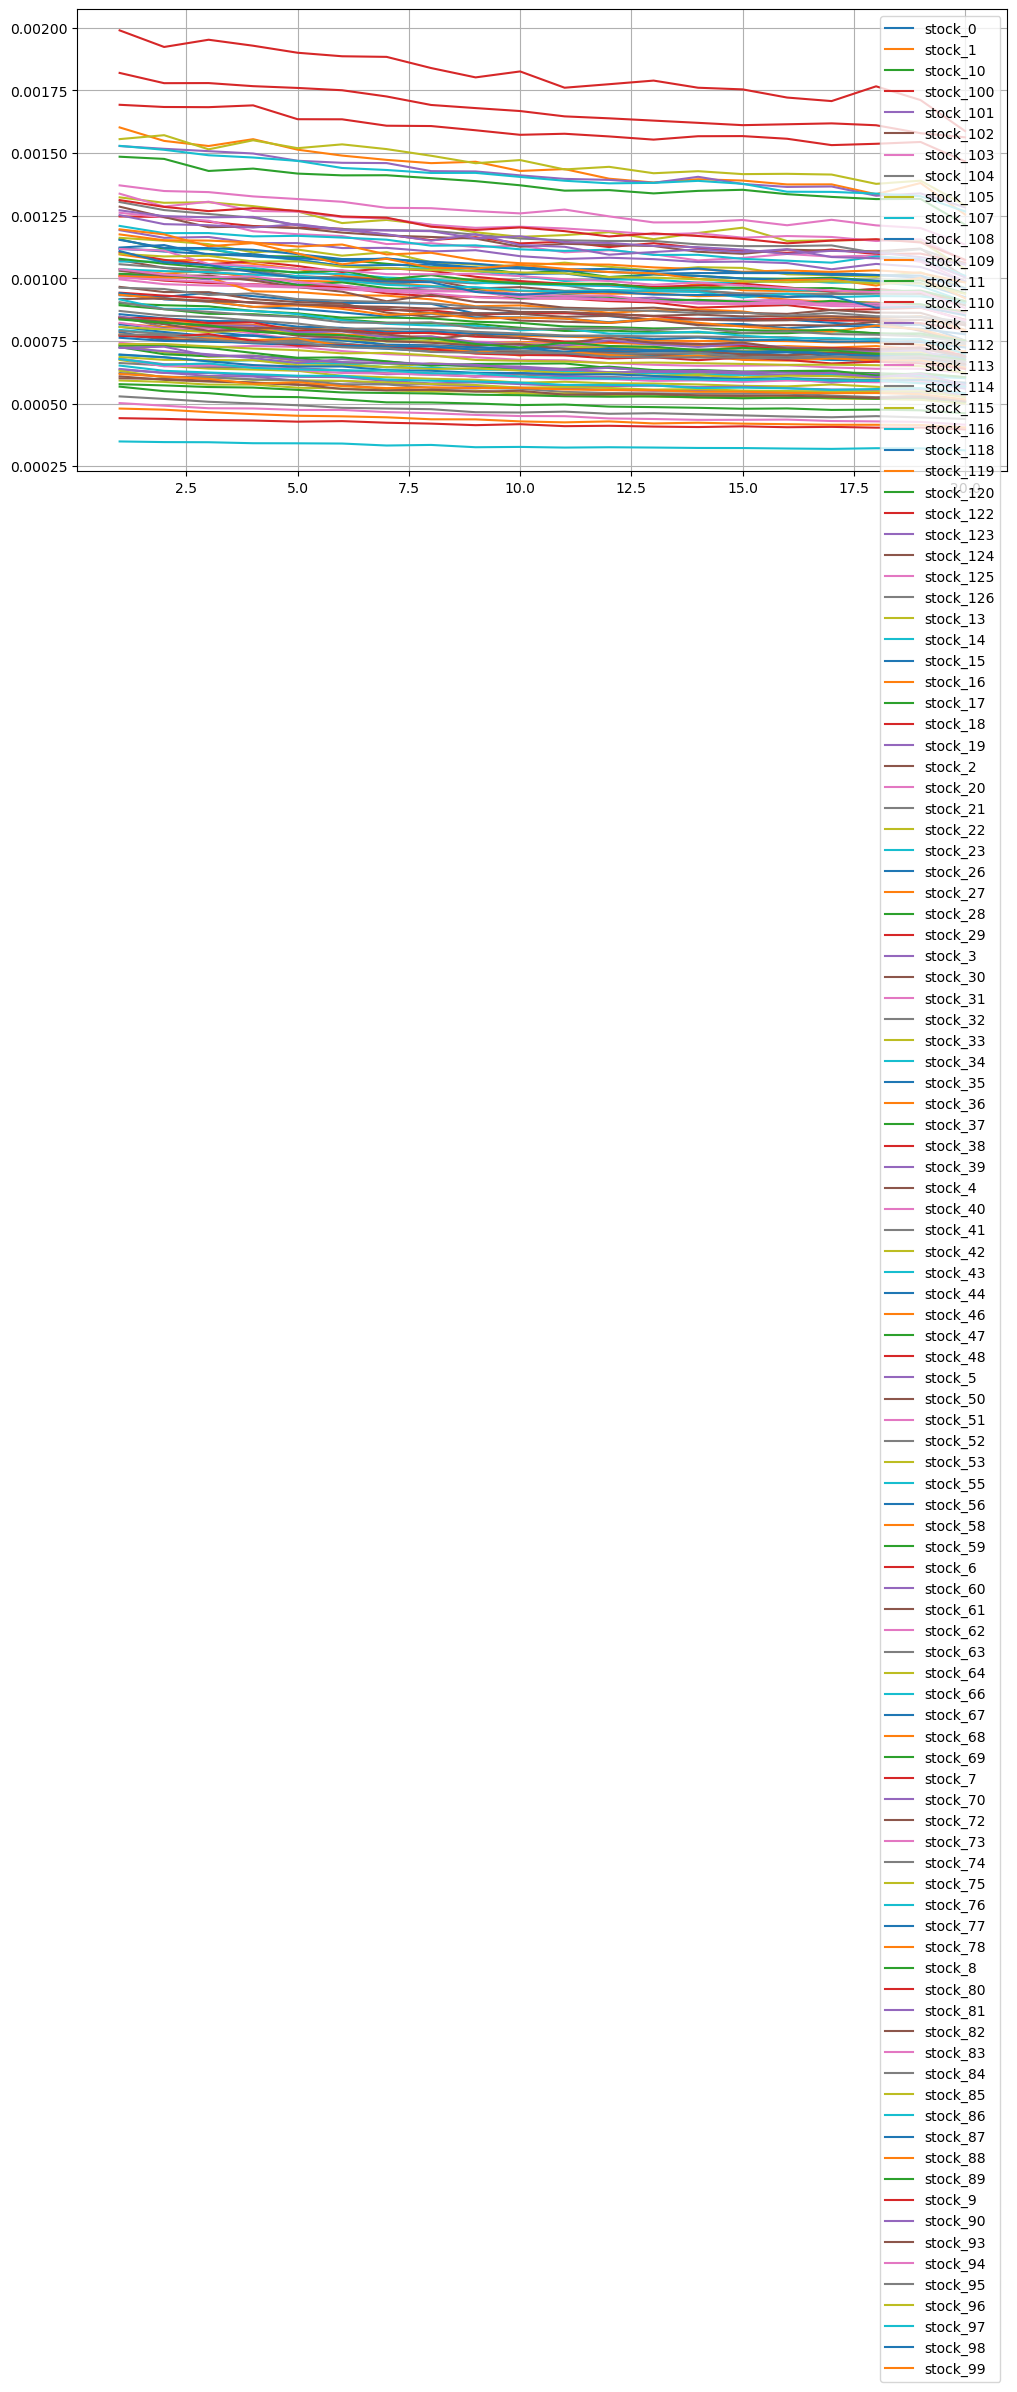

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for stock_name, df in volatilities.items():
    if df.empty:
        continue

    if "volatility" in df.columns:
        
        spread_mean = df.groupby('time_bucket')['volatility'].mean()
        plt.plot(spread_mean.index, spread_mean.values, label=stock_name)
    
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Investigating lag cut offs

In [1]:
import statsmodels.api as smt
from collections import defaultdict

data_dir = "pardata2"
lags_to_check = 5
grouped_stocks = defaultdict(list)

def detect_cutoff_lag(acf_vals, conf_int):
    for lag in range(1, len(acf_vals)):
        lower, upper = conf_int[lag]
        if lower < 0 < upper:  
            return lag - 1 
    return len(acf_vals) - 1

stock_data_by_cutoff = {}

for filename in os.listdir(data_dir):
    if filename.endswith(".parquet"):
        stock_name = os.path.splitext(filename)[0]
        file_path = os.path.join(data_dir, filename)

        df = pd.read_parquet(file_path)
        df = df[df['time_bucket'] != 0]
        spread_mean = df.groupby('time_bucket')['log_return'].mean().sort_index()

        acf_vals, confint = smt.tsa.acf(spread_mean, nlags=lags_to_check, alpha=0.05)
        cutoff = detect_cutoff_lag(acf_vals, confint)

        grouped_stocks[cutoff].append(stock_name)

        if cutoff not in stock_data_by_cutoff:
            stock_data_by_cutoff[cutoff] = spread_mean

print(f"The stocks without cutoff at 0:")
for cutoff, stocks in grouped_stocks.items():
    if cutoff !=0:
        print(f"Cutoff lag {cutoff}: {stocks}")

for cutoff, example_data in stock_data_by_cutoff.items():
    fig, axes = plt.subplots(2, 1, figsize=(10, 6))
    fig.suptitle(f"Group with cutoff lag = {cutoff}", fontsize=14)

    smt.graphics.tsa.plot_acf(example_data, lags=lags_to_check, alpha=0.05, ax=axes[0])
    axes[0].set_title("ACF")

    smt.graphics.tsa.plot_pacf(example_data, lags=lags_to_check, alpha=0.05, ax=axes[1])
    axes[1].set_title("PACF")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


NameError: name 'os' is not defined

In [ ]:
data_dir = "pardata2"
lags_to_check = 5
grouped_stocks = defaultdict(list)

def detect_pacf_cutoff(pacf_vals, conf_int):
    for lag in range(1, len(pacf_vals)):
        lower, upper = conf_int[lag]
        if lower < 0 < upper:
            return lag - 1
    return len(pacf_vals) - 1 

stock_data_by_cutoff = {}

for filename in os.listdir(data_dir):
    if filename.endswith(".parquet"):
        stock_name = os.path.splitext(filename)[0]
        file_path = os.path.join(data_dir, filename)

        df = pd.read_parquet(file_path)
        df = df[df['time_bucket'] != 0]
        spread_mean = df.groupby('time_bucket')['log_return'].mean().sort_index()

        pacf_vals, confint = smt.tsa.pacf(spread_mean, nlags=lags_to_check, alpha=0.05, method='ywm')
        cutoff = detect_pacf_cutoff(pacf_vals, confint)

        grouped_stocks[cutoff].append(stock_name)

        if cutoff not in stock_data_by_cutoff:
            stock_data_by_cutoff[cutoff] = (stock_name, spread_mean)

            
print(f"The stocks without cutoff at 0:")
for cutoff, stocks in grouped_stocks.items():
    if cutoff !=0:
        print(f"PACF cutoff lag {cutoff}: {stocks}")



## Investigating grouped models

In [52]:
import os
import pandas as pd

data_dir = "pardata2"
stock_data = {}

for filename in os.listdir(data_dir):
    if filename.endswith(".parquet"):
        stock_name = os.path.splitext(filename)[0]
        df = pd.read_parquet(os.path.join(data_dir, filename))
        df = df[df['time_bucket'] != 0]
        df = df.sort_values(by='time_bucket')
        stock_data[stock_name] = df[['time_bucket', 'log_return']]


In [59]:
from arch import arch_model

garch_results = {}

for stock, df in stock_data.items():
    try:
        returns = df['log_return'] * 1000
        if stock in grouped_stocks[0]:
            model = arch_model(returns, vol='GARCH', p=1, q=1)
        else:
            model = arch_model(returns, vol='GARCH', p=1, q=2)
        res = model.fit(disp="off")
        params = res.params.to_dict()
        garch_results[stock] = {
            "omega": params.get("omega", 0),
            "alpha": params.get("alpha[1]", 0),
            "beta": params.get("beta[1]", 0),
            "persistence": params.get("alpha[1]", 0) + params.get("beta[1]", 0),
            "loglikelihood": res.loglikelihood,
            "aic": res.aic,
            "bic": res.bic,
        }
    except Exception as e:
        print(f"Skipping {stock}: {e}")


C:\Users\karol\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08452. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\karol\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04056. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\karol\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

C:\Users\karol\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02921. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\karol\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02746. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\karol\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

C:\Users\karol\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01487. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\karol\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\karol\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05984. Parameter
estimation work better when this value is between 1 and 1000. The rec

C:\Users\karol\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05864. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\karol\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01564. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\karol\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

C:\Users\karol\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02533. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\karol\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [60]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

garch_df = pd.DataFrame.from_dict(garch_results, orient='index')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(garch_df)

kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)
garch_df["cluster"] = labels


C:\Users\karol\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\karol\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


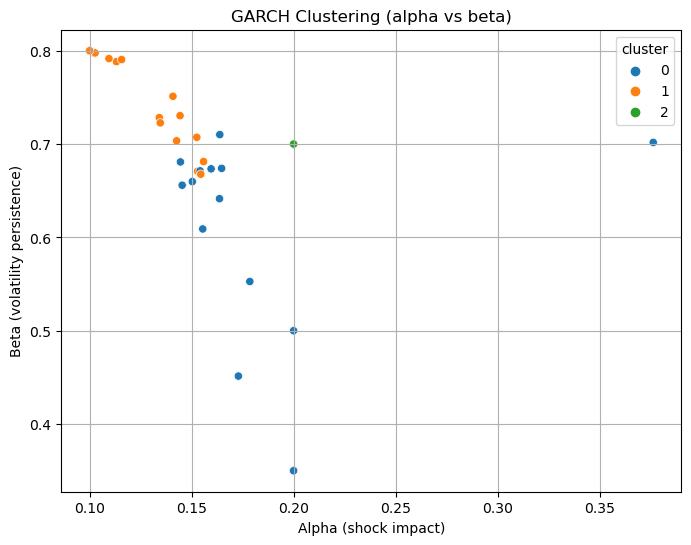

In [61]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=garch_df["alpha"],
    y=garch_df["beta"],
    hue=garch_df["cluster"],
    palette="tab10"
)
plt.title("GARCH Clustering (alpha vs beta)")
plt.xlabel("Alpha (shock impact)")
plt.ylabel("Beta (volatility persistence)")
plt.grid(True)
plt.show()


In [63]:
import numpy as np

forecast_horizon = 20 
cluster_forecasts = {}

for cluster_id in garch_df['cluster'].unique():
    stock_name = garch_df[garch_df['cluster'] == cluster_id].index[0]
    df = stock_data[stock_name]
    returns = df['log_return'] * 1000

    model = arch_model(returns, vol='GARCH', p=1, q=1)
    res = model.fit(disp="off")
    forecast = res.forecast(horizon=forecast_horizon)
    vol_forecast = np.sqrt(forecast.variance.values[-1])
    cluster_forecasts[cluster_id] = vol_forecast


C:\Users\karol\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04056. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\karol\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06615. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [64]:
for cluster, vol in cluster_forecasts.items():
    print(f"Cluster {cluster} - Example Volatility Forecast (next {forecast_horizon} steps):")
    print(vol)
    print("===")


Cluster 1 - Example Volatility Forecast (next 20 steps):
[0.29440833 0.30343694 0.31133892 0.318283   0.32440561 0.3298188
 0.3346158  0.33887505 0.34266312 0.34603692 0.34904546 0.35173115
 0.35413085 0.35627676 0.3581971  0.35991663 0.36145722 0.36283816
 0.36407653 0.36518747]
===
Cluster 2 - Example Volatility Forecast (next 20 steps):
[0.12084443 0.13114685 0.13977126 0.14710154 0.1533996  0.1588545
 0.16360848 0.16777193 0.1714326  0.17466162 0.17751752 0.18004911
 0.18229748 0.18429757 0.18607927 0.18766833 0.18908707 0.1903549
 0.19148876 0.19250353]
===
Cluster 0 - Example Volatility Forecast (next 20 steps):
[0.32387393 0.31783654 0.3123031  0.30723782 0.30260658 0.29837701
 0.29451846 0.29100203 0.28780051 0.28488839 0.28224179 0.27983844
 0.27765765 0.27568018 0.27388826 0.27226544 0.27079659 0.26946779
 0.26826623 0.26718021]
===


In [65]:
# For one cluster:
returns = df['log_return'] * 1000  # scale returns
from arch import arch_model

# Fit GARCH(1,1)
model = arch_model(returns, vol='GARCH', p=1, q=1)
res = model.fit(disp='off')

# Get conditional volatility (σ_t) and residuals (ε_t)
df['volatility_garch'] = res.conditional_volatility
df['residual'] = returns - res.params['mu'] - res.conditional_volatility

import numpy as np

window = 20

X, y = [], []
for i in range(window, len(df)):
    X.append(df['residual'].values[i - window:i])
    y.append(df['residual'].values[i])  # predict next residual (or volatility)

X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))  # [samples, timesteps, features]

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(50, input_shape=(X.shape[1], X.shape[2]), return_sequences=False),
    Dense(1)
])

model.compile(loss='mse', optimizer='adam')

model.fit(X, y, epochs=30, batch_size=16, verbose=1)


SyntaxError: invalid syntax (3360107527.py, line 3)

In [ ]:
y_pred = model.predict(X)

# Hybrid volatility = GARCH volatility + LSTM residual prediction
hybrid_vol = df['volatility_garch'].values[window:] + y_pred.flatten()

plt.plot(hybrid_vol, label="Hybrid Volatility")
plt.plot(df['volatility_garch'].values[window:], label="GARCH Only")
plt.legend()
plt.title("Hybrid GARCH-LSTM Volatility Forecast")
plt.show()


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler

# Cluster assignment: stock_name -> cluster_id
stock_cluster_map = {
    "stock_0": 0,
    "stock_1": 0,
    "stock_2": 1,
    # etc.
}

# Load data
data_dir = "pardata2"
cluster_data = {}

for filename in os.listdir(data_dir):
    if filename.endswith(".parquet"):
        stock_name = filename.replace(".parquet", "")
        cluster_id = stock_cluster_map.get(stock_name)
        if cluster_id is None:
            continue
        
        df = pd.read_parquet(os.path.join(data_dir, filename))
        df = df[df['time_bucket'] != 0]
        df['log_return'] = df['log_return'] * 100  # Rescale

        if cluster_id not in cluster_data:
            cluster_data[cluster_id] = []
        cluster_data[cluster_id].append(df['log_return'])

# GARCH-LSTM modeling per cluster
window = 20

for cluster_id, return_series_list in cluster_data.items():
    print(f"\n🚀 Training GARCH-LSTM for Cluster {cluster_id}")

    # Stack and concatenate all returns
    returns_all = pd.concat(return_series_list).reset_index(drop=True)

    # Fit GARCH(1,1)
    garch_model = arch_model(returns_all, vol='GARCH', p=1, q=1)
    garch_res = garch_model.fit(disp='off')

    vol_garch = garch_res.conditional_volatility
    residuals = returns_all - garch_res.params['mu'] - vol_garch

    # Prepare LSTM input
    X, y = [], []
    for i in range(window, len(residuals)):
        X.append(residuals[i - window:i].values)
        y.append(residuals[i])

    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Normalize residuals for LSTM
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

    # Define LSTM model
    model = Sequential([
        LSTM(50, input_shape=(X.shape[1], X.shape[2])),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    # Train LSTM
    model.fit(X, y_scaled, epochs=25, batch_size=16, verbose=1)

    # Predict residuals
    y_pred_scaled = model.predict(X)
    y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()

    # Hybrid volatility = GARCH + LSTM-predicted residual
    hybrid_vol = vol_garch.values[window:] + y_pred

    # Plot result
    plt.figure(figsize=(10, 4))
    plt.plot(vol_garch.values[window:], label="GARCH")
    plt.plot(hybrid_vol, label="Hybrid GARCH-LSTM")
    plt.title(f"Cluster {cluster_id} - Volatility Forecast")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [71]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import warnings
warnings.filterwarnings("ignore")

# 1️⃣ Load all .parquet files and fit GARCH
data_dir = "pardata2"
garch_params = []
returns_dict = {}

for filename in os.listdir(data_dir):
    if filename.endswith(".parquet"):
        stock_name = filename.replace(".parquet", "")
        df = pd.read_parquet(os.path.join(data_dir, filename))
        df = df[df['time_bucket'] != 0]
        if len(df) < 50:
            continue
        returns = df['log_return'] * 100
        try:
            model = arch_model(returns, vol='GARCH', p=1, q=1)
            res = model.fit(disp='off')
            omega = res.params['omega']
            alpha = res.params['alpha[1]']
            beta = res.params['beta[1]']
            persistence = alpha + beta
            garch_params.append([omega, alpha, beta, persistence])
            returns_dict[stock_name] = returns
        except Exception as e:
            print(f"⚠️ {stock_name} failed GARCH: {e}")

# 2️⃣ Cluster stocks by GARCH parameters
param_df = pd.DataFrame(garch_params, columns=['omega', 'alpha', 'beta', 'persistence'])
scaler = StandardScaler()
params_scaled = scaler.fit_transform(param_df)

k = 3  # You can choose dynamically or test multiple
kmeans = KMeans(n_clusters=k, random_state=42).fit(params_scaled)
param_df['cluster'] = kmeans.labels_

# Map stock names to clusters
stock_names = list(returns_dict.keys())
stock_cluster_map = {stock: int(cluster) for stock, cluster in zip(stock_names, kmeans.labels_)}

# 3️⃣ Run Hybrid GARCH-LSTM per cluster
window = 20
cluster_returns = {}

# Group returns by cluster
for stock, cluster in stock_cluster_map.items():
    if cluster not in cluster_returns:
        cluster_returns[cluster] = []
    cluster_returns[cluster].append(returns_dict[stock])

# Train model per cluster
for cluster_id, series_list in cluster_returns.items():
    print(f"\n🚀 Training GARCH-LSTM for Cluster {cluster_id}")

    all_returns = pd.concat(series_list).reset_index(drop=True)

    # Fit GARCH again on combined cluster series
    garch_model = arch_model(all_returns, vol='GARCH', p=1, q=1)
    res = garch_model.fit(disp='off')
    vol = res.conditional_volatility
    residuals = all_returns - res.params['mu'] - vol

    # Build LSTM dataset
    X, y = [], []
    for i in range(window, len(residuals)):
        X.append(residuals[i - window:i].values)
        y.append(residuals[i])

    X = np.array(X).reshape(-1, window, 1)
    y = np.array(y).reshape(-1, 1)

    # Scale y
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y)

    # Define and train LSTM
    model = Sequential([
        LSTM(50, input_shape=(X.shape[1], X.shape[2])),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y_scaled, epochs=25, batch_size=16, verbose=1)

    # Predict
    y_pred = model.predict(X)
    y_pred_inv = scaler_y.inverse_transform(y_pred).flatten()
    hybrid_vol = vol[window:] + y_pred_inv

    # Plot results
    plt.figure(figsize=(10, 4))
    plt.plot(vol[window:].values, label='GARCH')
    plt.plot(hybrid_vol, label='Hybrid GARCH-LSTM')
    plt.title(f'Cluster {cluster_id} - Volatility Forecast')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


ImportError: Traceback (most recent call last):
  File "C:\Users\karol\anaconda3\Lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# === 1. Custom Dataset ===
class VolatilityDataset(Dataset):
    def __init__(self, df, seq_length=10):
        self.seq_length = seq_length
        self.sequences = []

        grouped = df.groupby("time_id")
        for _, group in grouped:
            vols = group.sort_values("time_bucket")["volatility"].values
            for i in range(len(vols) - seq_length):
                seq = vols[i:i+seq_length]
                target = vols[i+seq_length]
                self.sequences.append((seq, target))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq, target = self.sequences[idx]
        return torch.tensor(seq, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

# === 2. Define LSTM Model ===
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = x.unsqueeze(-1)  # shape: (batch, seq_len, 1)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take last output
        return out.squeeze()

# === 3. Train the Model ===
def train_lstm(df, epochs=20, seq_length=10, batch_size=32):
    dataset = VolatilityDataset(df, seq_length=seq_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = LSTMModel()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for seq, target in dataloader:
            optimizer.zero_grad()
            output = model(seq)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(dataloader):.6f}")

    return model
